In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import adfuller, STL, SARIMAX
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.offsets import BQuarterEnd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = sm.datasets.macrodata.load_pandas().data
df

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [3]:
# Convert 'year' feature into a datetime object
df.year = pd.to_datetime(df.year, format='%Y')

# Combine the information contained in 'year' and 'quarter' into one feature
for i in range(203):
    if df.quarter[i] == 1.0:
        df.year[i] = df.year[i] + BQuarterEnd(1)
    elif df.quarter[i] == 2.0:
        df.year[i] = df.year[i] + BQuarterEnd(2)
    elif df.quarter[i] == 3.0: 
        df.year[i] = df.year[i] + BQuarterEnd(3)
    elif df.quarter[i] == 4.0:
        df.year[i] = df.year[i] + BQuarterEnd(4)

df = df.rename(columns={'year': 'date'})
df.head()

,date,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959-03-31,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959-06-30,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959-09-30,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959-12-31,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960-03-31,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


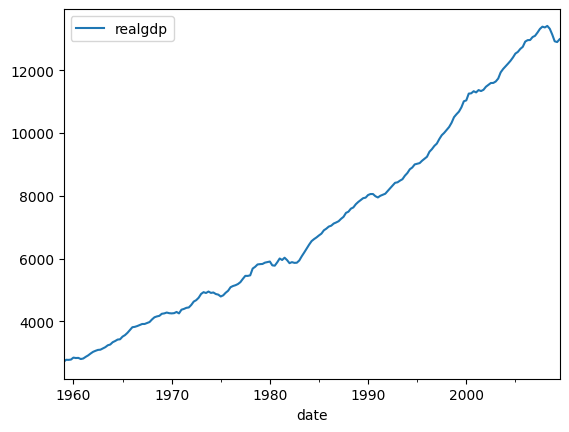

In [4]:
# Visualise the target
df.plot(y='realgdp', x='date');

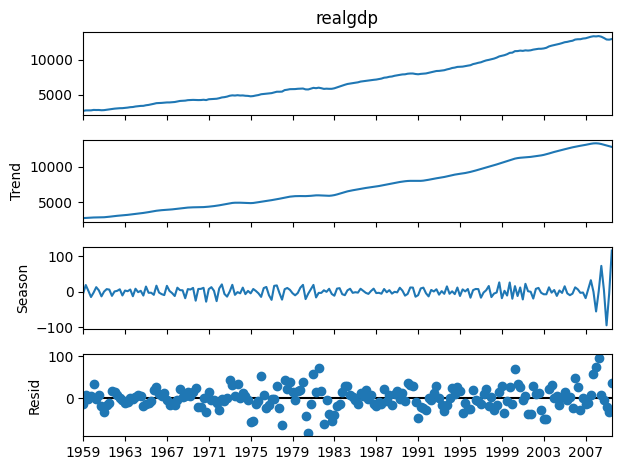

In [5]:
decomposition = STL(df.realgdp, period=4).fit()
decomposition.plot()
plt.xticks(range(0, 203, 16), range(1959, 2010, 4));

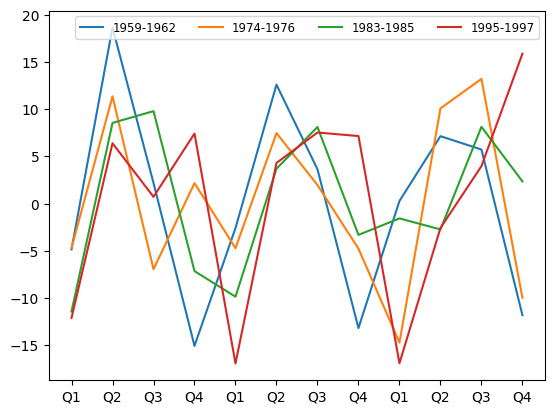

In [6]:
# Closer look at the seasonal component using four 3-year windows
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
quarterlist = []
quarterlist += 3* quarters

fig, ax = plt.subplots()
ax.plot(decomposition.seasonal.values[:12], label='1959-1962')
ax.plot(decomposition.seasonal.values[60:72], label='1974-1976')
ax.plot(decomposition.seasonal.values[96:108], label='1983-1985')
ax.plot(decomposition.seasonal.values[144:156], label='1995-1997')
ax.set_xticks(range(12), quarterlist)
ax.legend(ncols=4, fontsize='small');

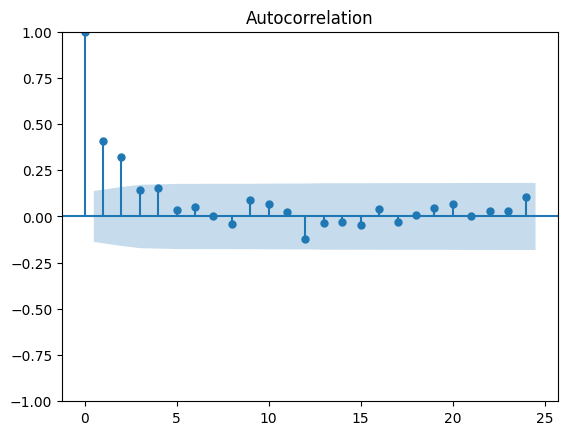

In [13]:
# Detect seasonality with an autocorrelation function plot
plot_acf(df.realgdp.diff()[1:], lags=24);

There does not seem to be a strong seasonal pattern.

### **ARIMA Model**

In [8]:
target = df.realgdp

# Function that prints out key Augmented Dickey-Fuller(ADF) test results
def print_adf_results(df):
    adf_result = adfuller(df)
    print(f'p-value: {adf_result[1]}')
    print(f'ADF Test Statistic: {adf_result[0]}')
    for key, value in adf_result[4].items():
        print(f'{key} Critical Value: {value}')

# Perform first-order differencing and ADF test to check for stationarity
target_1diff = target.diff()[1:]
print_adf_results(target_1diff)

p-value: 3.327882187668224e-08
ADF Test Statistic: -6.305695561658106
1% Critical Value: -3.463476079125
5% Critical Value: -2.876102355
10% Critical Value: -2.574532225


The p-value is <0.05 and the ADF test statistic is a greater negative value than all critical values, suggesting that first-order differencing is enough to induce stationary in the time series.

In [9]:
train = df[:182].realgdp
test = df[182:][['date', 'realgdp']] # 5-year horizon

In [10]:
# Create a function that finds the best relative p and q orders using Akaike Information Criterion(AIC)
def find_orders(max_p, max_q, d, endog, exog=None):
    results = []
    orderslist = [(p, q) for p in range(max_p) for q in range(max_q)]

    for orders in orderslist:
        try:
            model = SARIMAX(endog=train, exog=exog, order=(orders[0], d, orders[1])).fit()
        except:
            continue
        results.append([orders, model.aic])
    
    results_df = pd.DataFrame(results, columns=['p, q', 'AIC']).sort_values('AIC')
    return results_df.head()

find_orders(4, 4, 1, train)

,"p, q",AIC
13,"(3, 1)",1938.031607
14,"(3, 2)",1939.148581
7,"(1, 3)",1939.643624
11,"(2, 3)",1942.249345
15,"(3, 3)",1942.321292


In [11]:
ARIMAmodel = SARIMAX(train, order=(3, 1, 1)).fit()

    lb_pvalue
1    0.810435
2    0.930619
3    0.982862
4    0.993812
5    0.997177
6    0.999326
7    0.999691
8    0.999928
9    0.999971
10   0.999993


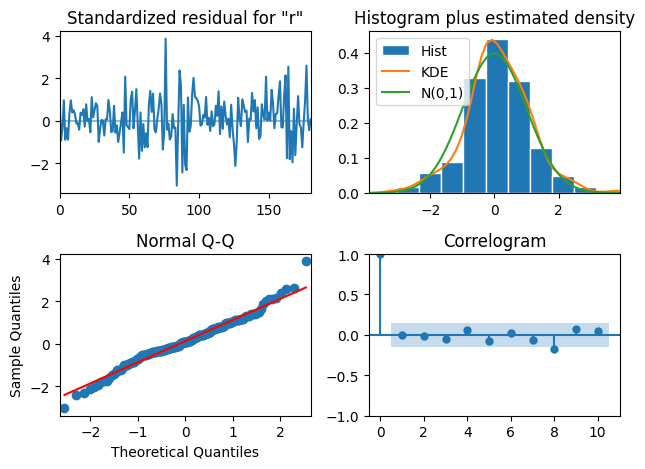

In [12]:
# Perform residual analysis to confirm that the model adequately captures the trend and seasonal components of the time series
def resid_analysis(model):
    model.plot_diagnostics()
    plt.tight_layout()

    print(acorr_ljungbox(ARIMAmodel.resid)[['lb_pvalue']])

resid_analysis(ARIMAmodel)

The p-values of the residuals are all significantly greater than 0.5. Visually, the residuals resemble white noise. The model passes both the qualitative and quantitative aspect of residual analysis, which suggests that it adequately captures the predictable patterns of the time series.

In [13]:
test['ARIMA'] = ARIMAmodel.forecast(len(test))

In [14]:
def print_mape(y_true, y_pred):
    # Calculate absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)
    
    # Handle division by zero errors
    ape[np.isinf(ape)] = 0.0
    
    # Calculate mean of absolute percentage error
    mape = np.mean(ape) * 100
    
    print(f'Mean absolute percentage error for {y_pred.name} model is: {mape:.2f}%')

print_mape(test.realgdp, test.ARIMA)

Mean absolute percentage error for ARIMA model is: 1.55%


### **ARIMAX Model**

In [15]:
# Create deterministic features
dp = DeterministicProcess(df.date, period=4, order=2)
df = pd.merge(df, dp.in_sample().reset_index(), how='left', on='date')
df['year'] = df.date.dt.year
df.head()

,date,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,trend,trend_squared,year
0,1959-03-31,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,1.0,1.0,1959
1,1959-06-30,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,2.0,4.0,1959
2,1959-09-30,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,3.0,9.0,1959
3,1959-12-31,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,4.0,16.0,1959
4,1960-03-31,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,5.0,25.0,1960


In [16]:
exog_train = df.loc[:181, ['quarter', 'trend', 'trend_squared', 'year']]
exog_test = df.loc[182:, ['quarter', 'trend', 'trend_squared', 'year']]

In [17]:
# Find the p and q orders for the model with the exogenous variables: realcons, realdpi, and cpi
find_orders(4, 4, 1, train, exog_train)

,"p, q",AIC
8,"(2, 0)",1932.750080
9,"(2, 1)",1933.313839
2,"(0, 2)",1933.799977
12,"(3, 0)",1934.245386
15,"(3, 3)",1934.705752


In [18]:
ARIMAXmodel = SARIMAX(endog=train, exog=exog_train, order=(2, 1, 0)).fit()

In [19]:
test['ARIMAX'] = ARIMAXmodel.forecast(len(test), exog=exog_test)
print_mape(test.realgdp, test.ARIMAX)

Mean absolute percentage error for ARIMAX model is: 1.74%


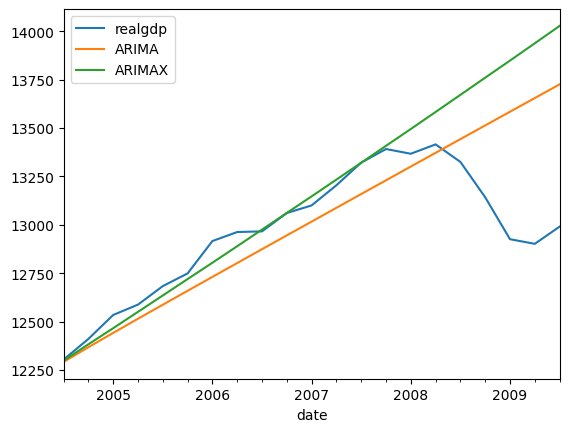

In [20]:
test.plot(x='date');

The ARIMAX model performs worse than the ARIMA model. However, it outperforms the ARIMA model prior to the Great Recession.

### **Playing with future knowledge**

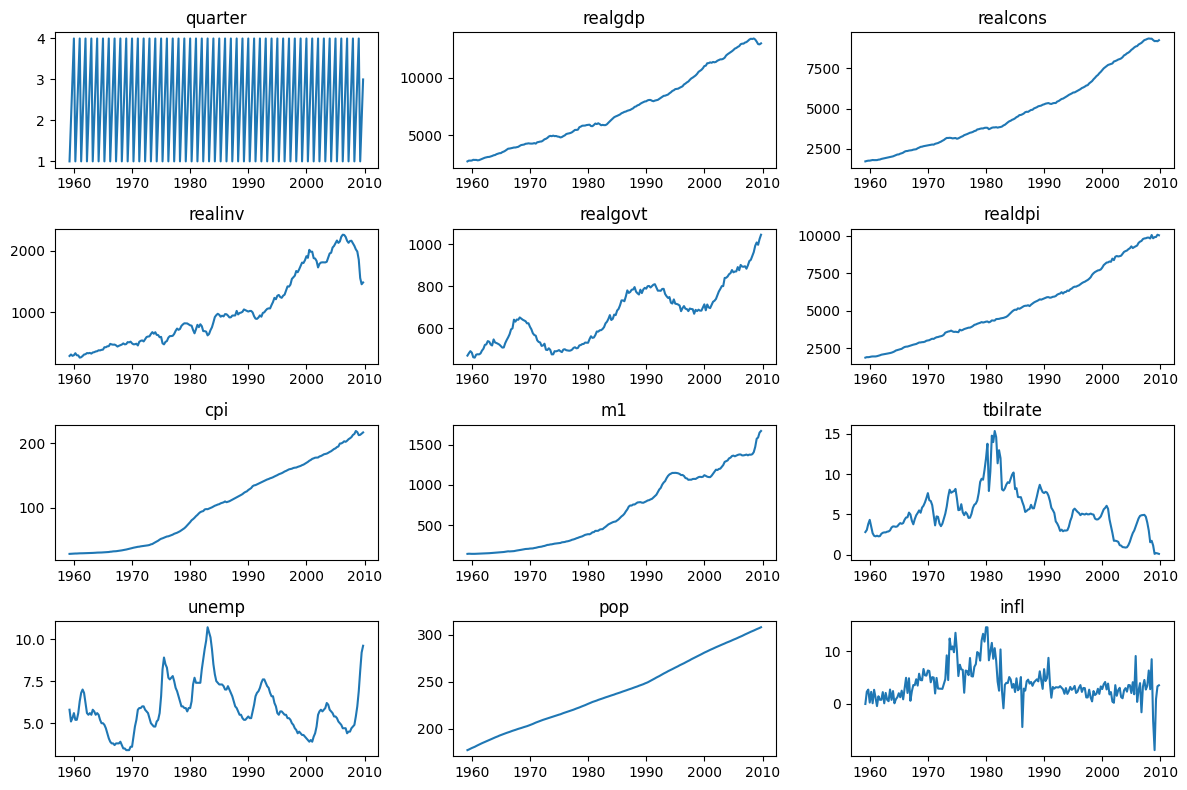

In [21]:
# Get an overview of all features
fig, axes = plt.subplots(4, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    ax.plot(df.date, df.iloc[:, i+1])
    ax.set_title(df.columns[i+1])

plt.tight_layout()

In [22]:
# Imagine a world where we have super accurate forecasts of data like realcons, realdpi, cpi, realinv, infl, and unemp
f_exog_train = df.loc[:181, ['realcons', 'realdpi', 'cpi',  'infl', 'unemp']]
f_exog_test = df.loc[182:, ['realcons', 'realdpi', 'cpi', 'infl', 'unemp']]

In [23]:
find_orders(4, 4, 1, train, f_exog_train)

,"p, q",AIC
1,"(0, 1)",1791.076806
5,"(1, 1)",1793.002807
2,"(0, 2)",1793.089300
4,"(1, 0)",1793.404543
11,"(2, 3)",1793.501551


In [24]:
model = SARIMAX(train, f_exog_train, order=(0, 1, 1)).fit()

In [25]:
test['Fun'] = model.forecast(len(test), exog=f_exog_test)
print_mape(test.realgdp, test.Fun)

Mean absolute percentage error for Fun model is: 0.65%


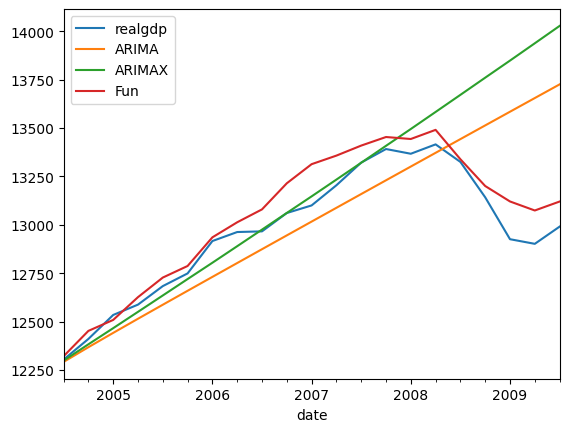

In [26]:
test.plot(x='date');